In [1]:
!pip install statsforecast

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.9/110.9 kB 1.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 275.0/275.0 kB 14.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.0/57.0 kB 6.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 169.2/169.2 kB 15.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.6/154.6 kB 15.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 299.6/299.6 kB 24.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 144.2/144.2 kB 13.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 135.3/135.3 kB 14.7 MB/s eta 0:00:00
  Created wheel for fugue-sql-antlr: filename=fugue_sql_antlr-0.1.6-py3-none-any.whl size=158045 sha256=55ee29149b44886024ddd5334072f51badc3ae17964c91a1d6405243eb356cc3
  Stored in directory: /root/.cache/pip/wheels/c8/54/a1/b294b8b33c6107946b5720b3acb1fce07b97bbbc9677a501ce
Successfully built fugue-sql-antlr


In [2]:
!pip install pmdarima

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 8.2 MB/s eta 0:00:00


In [3]:
!pip install prophet

In [51]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_predict
from statsforecast import StatsForecast
from statsforecast.models import Naive, SeasonalNaive, SeasonalWindowAverage, AutoARIMA
from statsmodels.tsa.arima.model import ARIMA
from pmdarima.arima import ndiffs, auto_arima
from prophet import Prophet


**Importando arquivos para o projeto**

---

Iniciamos importando a base histórica diária dos últimos 10 anos.


In [52]:
dados_ibovespa= pd.read_csv("Dados Historicos - Ibovespa.csv", sep=",")

In [53]:
dados_ibovespa.head()

,Data,Último,Abertura,Máxima,Mínima,Vol.,Var%
0,29.08.2023,118.069,118.051,118.493,117.400,"5,94M","0,81%"
1,28.08.2023,117.121,115.838,117.253,115.836,"9,60M","1,11%"
2,25.08.2023,115.837,117.025,117.252,115.397,"9,21M","-1,02%"
3,24.08.2023,117.026,118.135,118.136,116.848,"9,20M","-0,94%"
4,23.08.2023,118.135,116.160,118.135,116.159,"11,54M","1,70%"


In [54]:
dados_ibovespa.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 663 entries, 0 to 662
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Data      663 non-null    object 
 1   Último    663 non-null    float64
 2   Abertura  663 non-null    float64
 3   Máxima    663 non-null    float64
 4   Mínima    663 non-null    float64
 5   Vol.      663 non-null    object 
 6   Var%      663 non-null    object 
dtypes: float64(4), object(3)
memory usage: 36.4+ KB


Alteramos o campo Data para formato datetime, tiramos o formato float do campo com o valor de fechamento, e setamos a data como Index.
Além disso, removemos as colunas que não seriam interessantes nesse primeiro momento.

In [55]:
dados_ibovespa = dados_ibovespa.rename(columns={'Data':'ds','Último':'y'})
dados_ibovespa["ds"]= pd.to_datetime(dados_ibovespa['ds'],format= "%d.%m.%Y")

dados_ibovespa= dados_ibovespa.sort_values(by='ds', ascending=True)

In [56]:

dados_ibovespa.drop("Abertura", inplace=True, axis=1)
dados_ibovespa.drop("Máxima", inplace=True, axis=1)
dados_ibovespa.drop("Mínima", inplace=True, axis=1)
dados_ibovespa.drop("Vol.", inplace=True, axis=1)
dados_ibovespa['Var%']= dados_ibovespa['Var%'].str.replace('%','').str.replace(',', '.').astype(float)


Verificando valores nulos

In [57]:
dados_ibovespa.isnull().sum()

ds      0
y       0
Var%    0
dtype: int64

Avaliando informações da base histórica

In [58]:
dados_ibovespa.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 663 entries, 662 to 0
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   ds      663 non-null    datetime64[ns]
 1   y       663 non-null    float64       
 2   Var%    663 non-null    float64       
dtypes: datetime64[ns](1), float64(2)
memory usage: 20.7 KB


In [59]:
dados_ibovespa.head()

,ds,y,Var%
662,2021-01-04,118.855,-0.14
661,2021-01-05,119.376,0.44
660,2021-01-06,119.100,-0.23
659,2021-01-07,122.386,2.76
658,2021-01-08,125.077,2.20


In [60]:
dados_ibovespa.mean()

<ipython-input-60-5a69499c22a0>:1: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  dados_ibovespa.mean()


y       112.672267
Var%      0.006968
dtype: float64

In [61]:
dados_ibovespa.describe()

,y,Var%
count,663.000000,663.000000
mean,112.672267,0.006968
std,7.403337,1.278828
min,96.121000,-4.870000
25%,107.407000,-0.780000
50%,112.256000,0.040000
75%,118.187000,0.830000
max,130.776000,5.540000


# Análise exploratória de dados (EDA)

Plotamos um gráfico com a evolução do fechamento da bolsa, dos últimos 10 anos, para analisar o comportamento do período de interesse

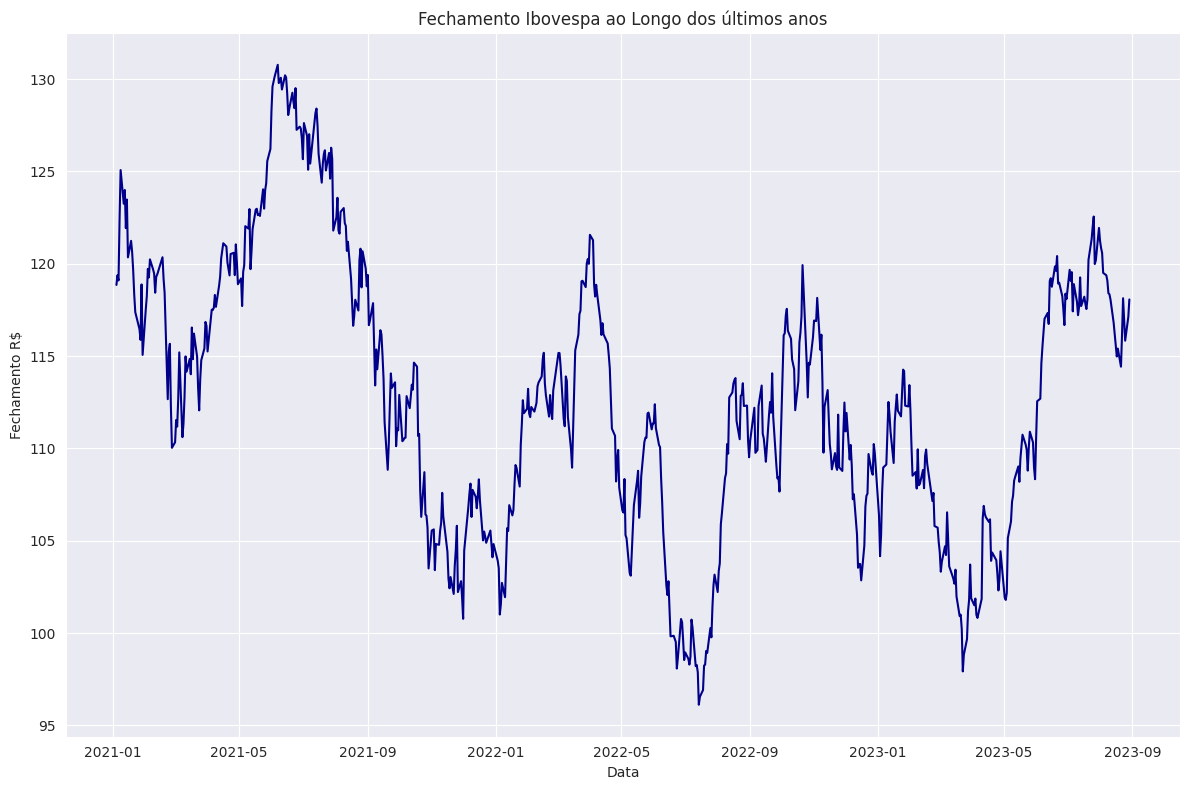

In [62]:
sns.set_style('darkgrid')
f, ax = plt.subplots(figsize=(12,8))
sns.lineplot(data=dados_ibovespa, x='ds', y='y', ax=ax, color='darkblue')

plt.title('Fechamento Ibovespa ao Longo dos últimos anos')
plt.xlabel('Data')
plt.ylabel('Fechamento R$')
plt.tight_layout()

Posteriormente, calculamos a média e o desvio padrão dos dados

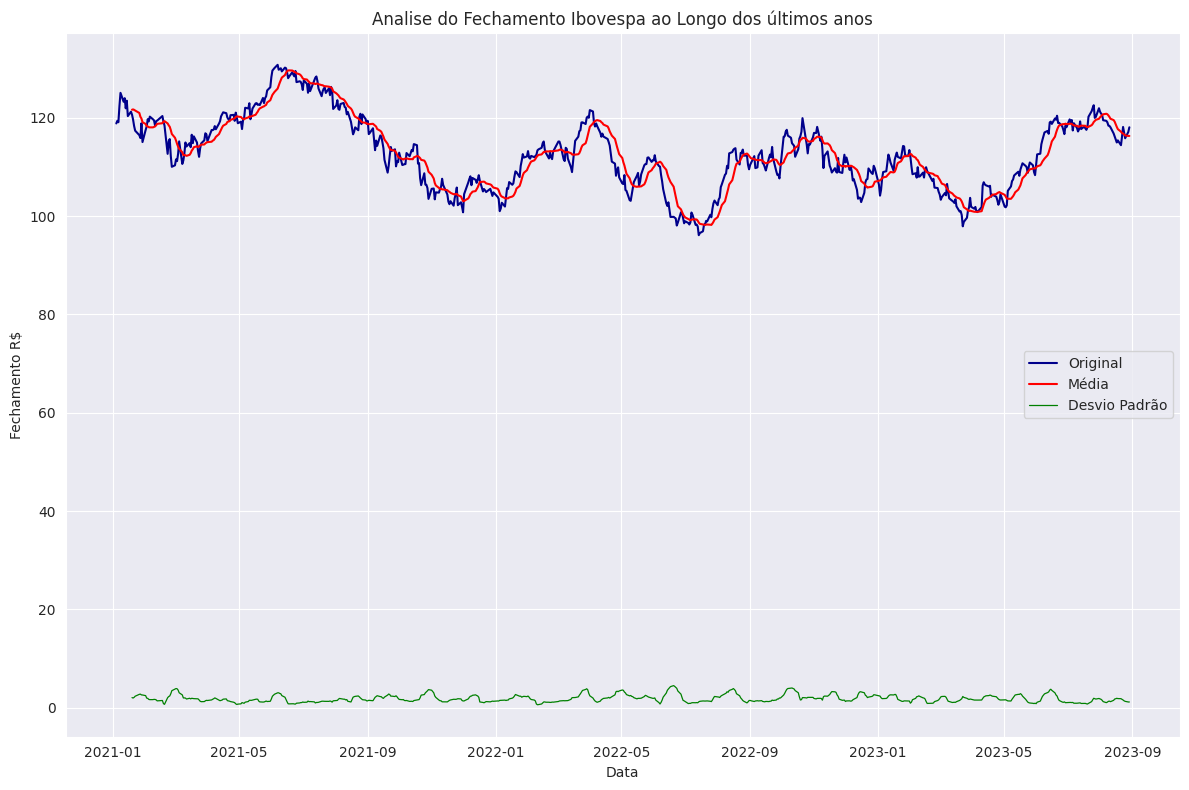

In [63]:
#Calculando a média móvel e o desvio padrão
m_a = dados_ibovespa['y'].rolling(12).mean()
std = dados_ibovespa['y'].rolling(12).std()

f, ax = plt.subplots(figsize=(12, 8))
dados_ibovespa['ds'] = pd.to_datetime(dados_ibovespa['ds'])
plt.plot(dados_ibovespa['ds'], dados_ibovespa['y'], color='darkblue')
plt.plot(dados_ibovespa['ds'], m_a, color='red')
plt.plot(dados_ibovespa['ds'], std, color='green', linewidth=0.9)

plt.title('Analise do Fechamento Ibovespa ao Longo dos últimos anos')
plt.xlabel('Data')
plt.ylabel('Fechamento R$')
plt.legend(['Original', 'Média', 'Desvio Padrão'])
plt.tight_layout()

Analisamos a frequência histórica dos valores de fechamento

Text(0, 0.5, 'Frequência')

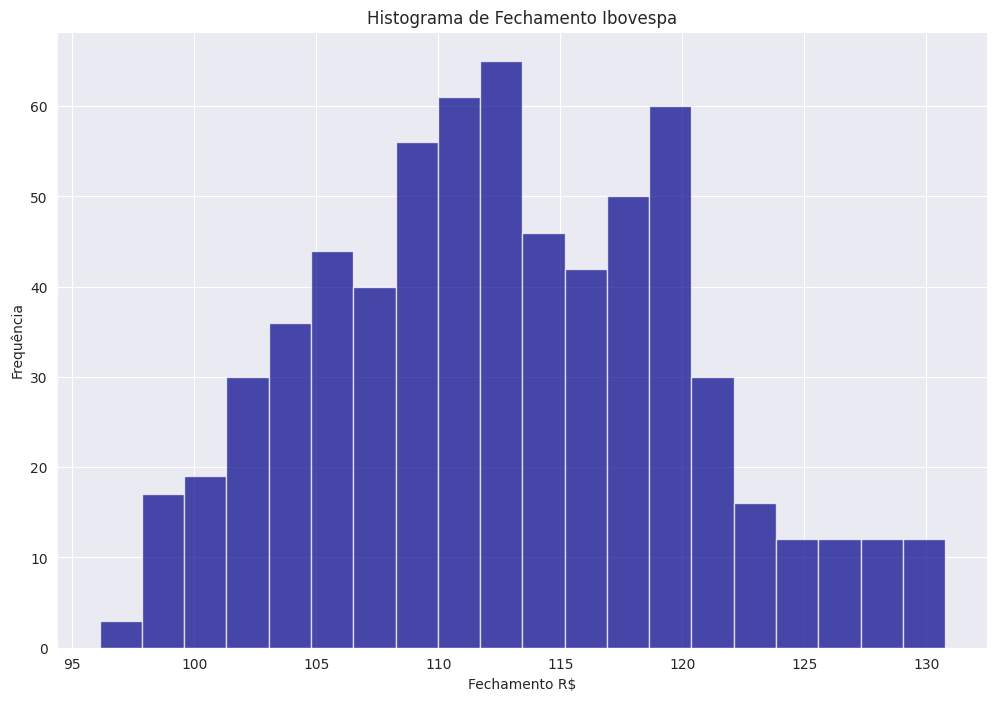

In [64]:
plt.figure(figsize=(12, 8))
n,bins, pacthes=plt.hist(dados_ibovespa['y'], bins=20, color='darkblue', alpha=0.7)


plt.title('Histograma de Fechamento Ibovespa')
plt.xlabel('Fechamento R$')
plt.ylabel('Frequência')

No gráfico acima, vemos que os valores que mais se repetem no fechamento diário das ações são entre 50 e 60 Mil

Analisando a %Var entre os anos

Text(0, 0.5, 'Variação Percentual')

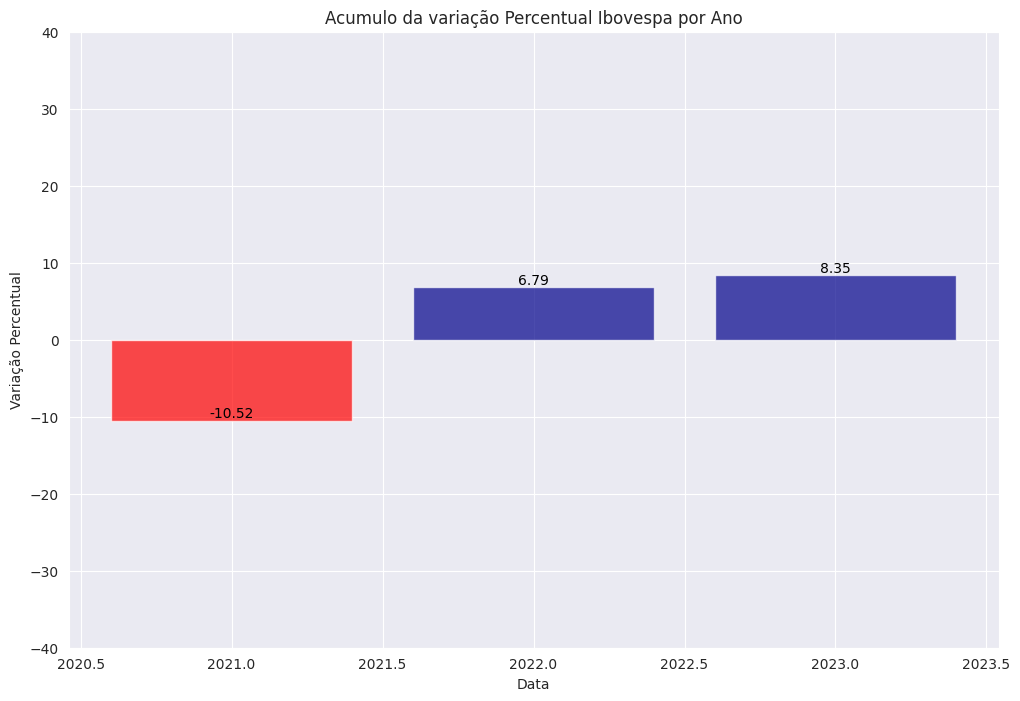

In [65]:
# Agrupando os valores de 'Var%' por ano
var_por_ano = dados_ibovespa.groupby(dados_ibovespa['ds'].dt.year)['Var%'].sum()

plt.figure(figsize=(12, 8))
bars=plt.bar(var_por_ano.index, var_por_ano.values, color=['darkblue' if v >= 0 else 'red' for v in var_por_ano.values], alpha=0.7)
plt.ylim(-40, 40)

for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, height, f'{height:.2f}', ha='center', va='bottom', color='black')

plt.title('Acumulo da variação Percentual Ibovespa por Ano')
plt.xlabel('Data')
plt.ylabel('Variação Percentual')


# Decomposição dos dados

In [66]:
#Excluindo coluna "Var%"
dados_ibovespa.drop("Var%", inplace=True, axis=1)

dados_ibovespa.set_index('ds', inplace=True)



In [67]:
# Decompondo os dados, utilizando period=30 pois é uma base de diaria
resultados = seasonal_decompose(dados_ibovespa,model='multiplicative', period=30)

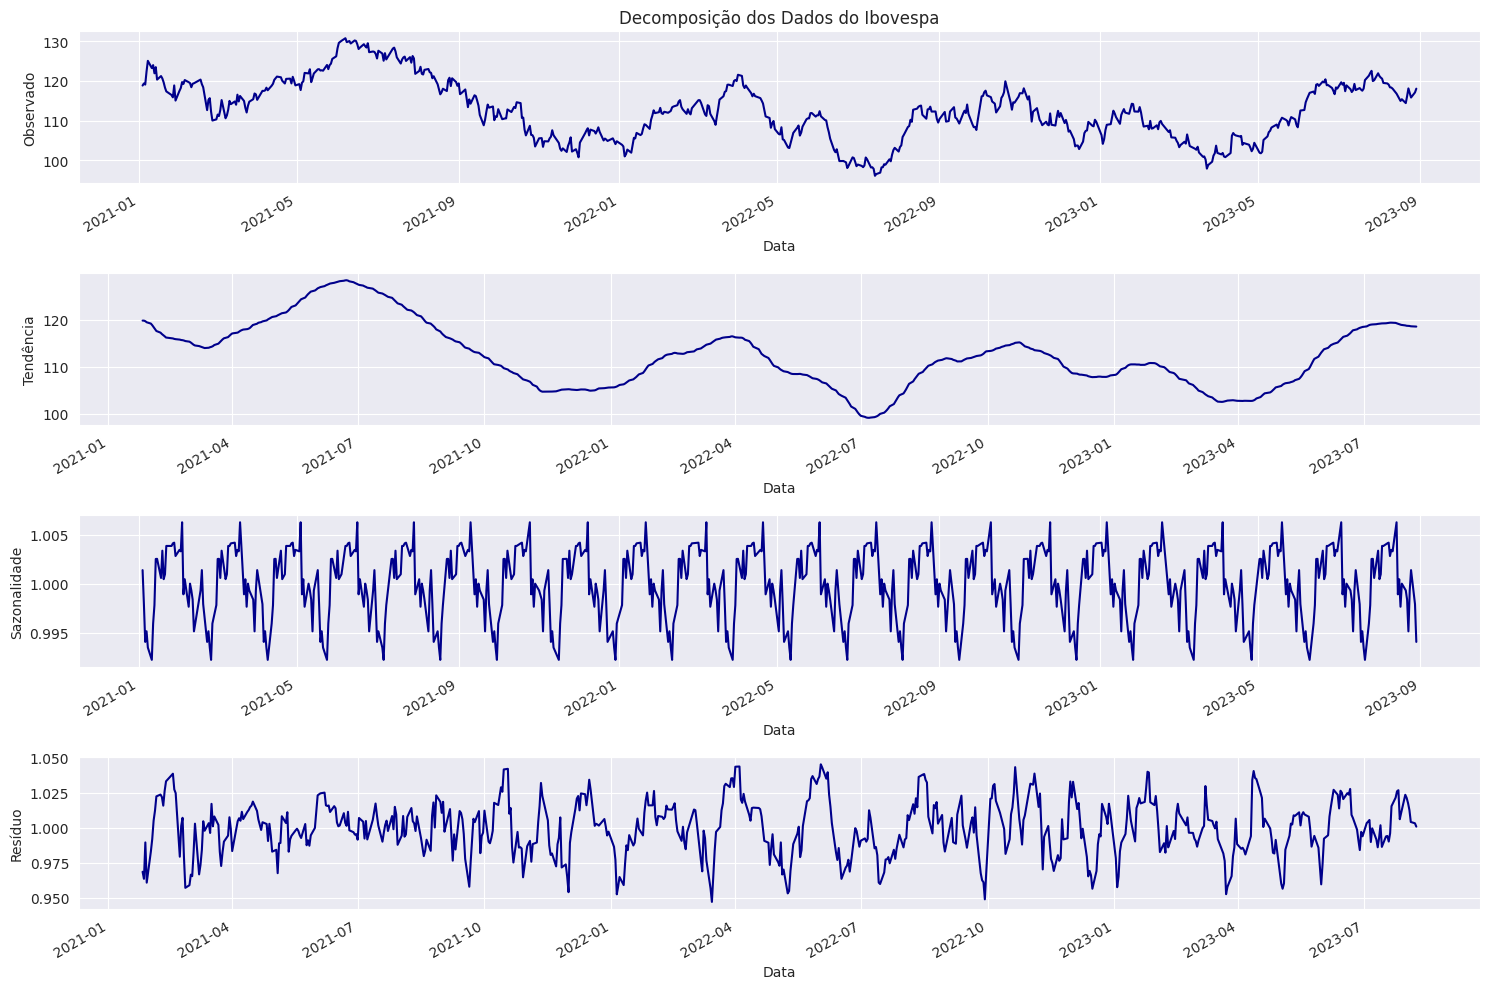

In [68]:
fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1, figsize=(15,10))

# Plotando a serie decomposta
plt.subplot(4, 1, 1)
resultados.observed.plot(ax=ax1, color='darkblue')
plt.ylabel('Observado')
plt.xlabel("Data")
plt.title('Decomposição dos Dados do Ibovespa')


plt.subplot(4, 1, 2)
resultados.trend.plot(ax=ax2, color='darkblue')
plt.ylabel('Tendência')
plt.xlabel("Data")

plt.subplot(4, 1, 3)
resultados.seasonal.plot(ax=ax3 , color='darkblue')
plt.ylabel('Sazonalidade')
plt.xlabel("Data")

plt.subplot(4, 1, 4)
resultados.resid.plot(ax=ax4 , color='darkblue')
plt.ylabel('Resíduo')
plt.xlabel("Data")

plt.tight_layout()
plt.show()

**Realizando o teste de Dickey-Fuller**

In [69]:
X = dados_ibovespa.values
result = adfuller(X)

print("Teste ADF")
print(f"Teste Estatístico: {result[0]}")
print(f"P-Value: {result[1]}")
print("Valores críticos:")

for key, value in result[4].items():
  print(f"\t{key}: {value}")

Teste ADF
Teste Estatístico: -2.5156904097097144
P-Value: 0.11170320335613626
Valores críticos:
	1%: -3.4402666733359175
	5%: -2.8659158113822065
	10%: -2.569100276740811


Pelo teste de Dickey-Fuller acima, podemos ver que o p-value está um pouco acima esperado (11%) e o teste estatístico é maior do que os valores críticos.

Dessa forma, a base não é estacionária.

Vamos aplicar alguns métodos para deixá-la estacionária.

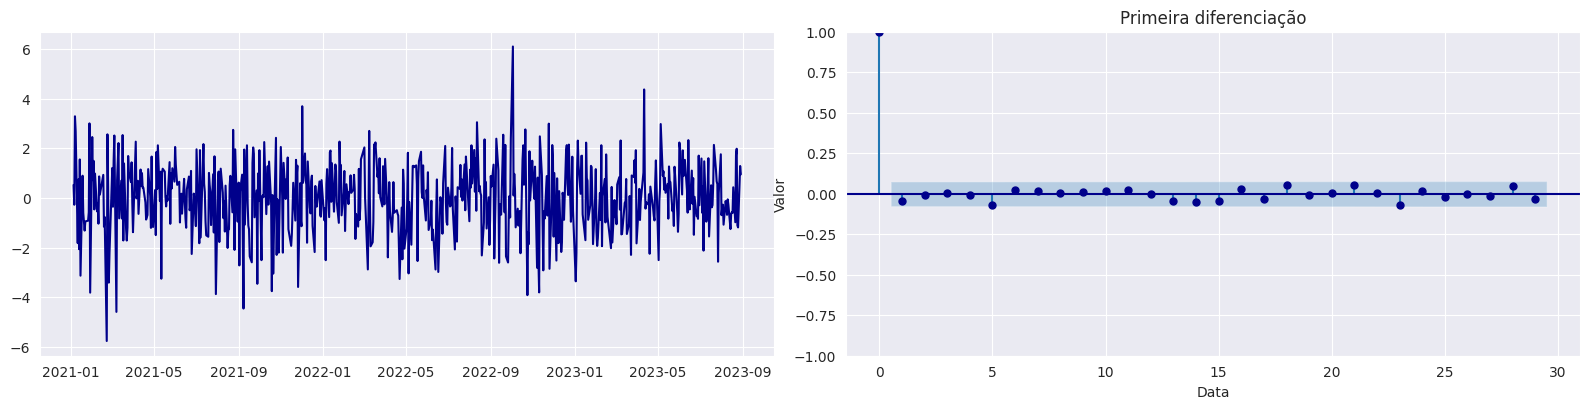

In [70]:
#Aplicando método de diferenciação
df_diff = dados_ibovespa.diff().dropna()

f, (ax1, ax2) = plt.subplots(1,2, figsize= (16,4))
ax1.plot(df_diff, color="darkblue")
plot_acf(df_diff,color="darkblue",  ax=ax2)
plt.tight_layout()

plt.title('Primeira diferenciação')
plt.xlabel('Data')
plt.ylabel('Valor')
plt.grid(True)
plt.show()


Text(44.222222222222214, 0.5, 'Valor')

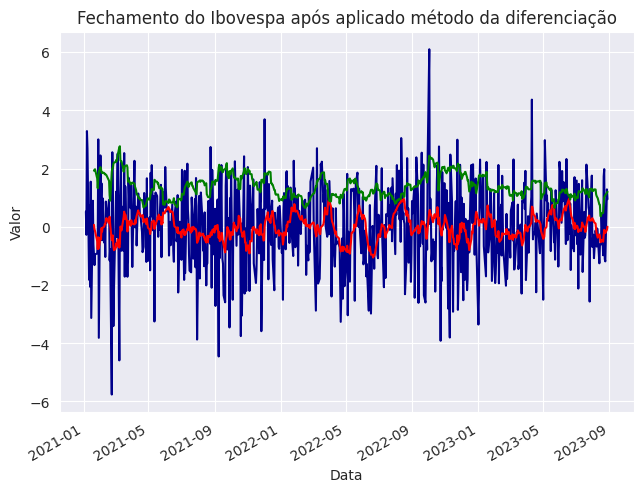

In [71]:
ma_s = df_diff.rolling(12).mean()
std = df_diff.rolling(12).std()

f, ax = plt.subplots()
df_diff.plot(ax=ax, legend=False, color="darkblue")
ma_s.plot(ax=ax, legend=False, color='red')
std.plot(ax=ax, legend=False, color='green')
plt.tight_layout()

plt.title('Fechamento do Ibovespa após aplicado método da diferenciação')
plt.xlabel('Data')
plt.ylabel('Valor')

Utilizamos também a biblioteca pdmarima para determinar o número de derivadas necessárias

In [72]:
ndiffs(dados_ibovespa.index.sort_values(), test="adf")

1

A partir do resultado acima, tivemos a confirmação de que era necessário apenas uma diferenciação para aplicar o teste.

Realizando novamente teste de Dickey-Fuller


In [73]:
X_s = df_diff.values
result_s = adfuller(X_s)

print("Teste ADF")
print(f"Teste Estatístico: {result_s[0]}")
print(f"P-Value: {result_s[1]}")
print("Valores críticos:")

for key, value in result_s[4].items():
  print(f"\t{key}: {value}")

Teste ADF
Teste Estatístico: -26.785848428328876
P-Value: 0.0
Valores críticos:
	1%: -3.4402817347322583
	5%: -2.8659224464259823
	10%: -2.5691038118332603


Pelo teste estatístico acima, e o valor de p-baixo podemos ver que a série se tornou estacionária

# **Funções de autocorrelação**

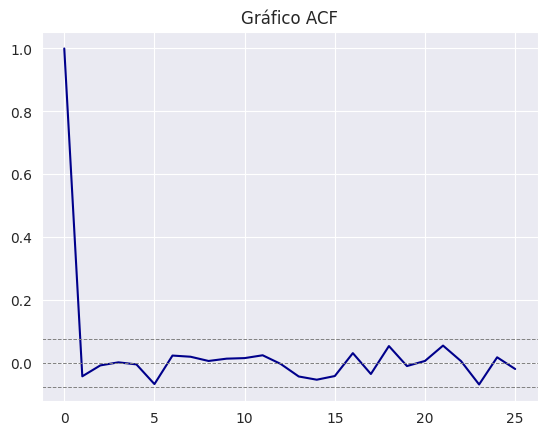

In [74]:
lag_acf = acf(df_diff.dropna(), nlags=25)

plt.plot(lag_acf, color="darkblue")

plt.axhline(y= -1.96/(np.sqrt((len(df_diff) -1))), linestyle='--', color='gray',linewidth=0.7)
plt.axhline(y=0, linestyle='--', color='gray',linewidth=0.7)
plt.axhline(y= 1.96/(np.sqrt((len(df_diff) -1))), linestyle='--', color='gray',linewidth=0.7)

plt.title("Gráfico ACF")
plt.show()

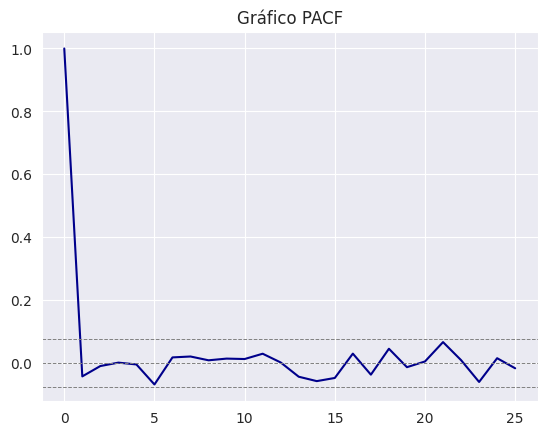

In [75]:
lag_pacf = pacf(df_diff.dropna(), nlags=25)

plt.plot(lag_pacf, color="darkblue")

plt.axhline(y= -1.96/(np.sqrt((len(df_diff) -1))), linestyle='--', color='gray',linewidth=0.7)
plt.axhline(y=0, linestyle='--', color='gray',linewidth=0.7)
plt.axhline(y= 1.96/(np.sqrt((len(df_diff) -1))), linestyle='--', color='gray',linewidth=0.7)

plt.title("Gráfico PACF")
plt.show()

O modelo ARIMA é especificado em termos de parâmetros (P, D, Q) .

Pelo ponto em que cada gráfico passa em zero pela primeira vez, temos o valor de P e Q.

Pelos gráfico ACF, vemos que o valor de Q é 1, e o valor de P é 1

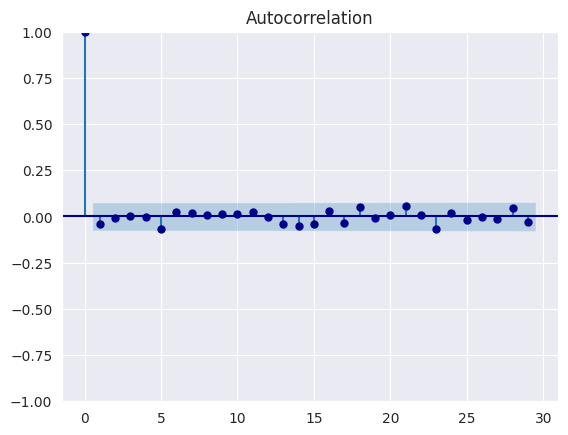

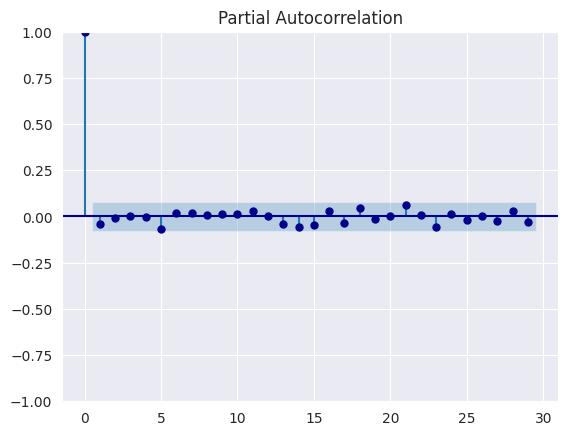

In [76]:
plot_acf(df_diff, color='darkblue')
plot_pacf(df_diff, color='darkblue')
plt.show()

Dividimos a base para treino e teste

In [77]:
dados_ibovespa.index.sort_values(ascending=True)

DatetimeIndex(['2021-01-04', '2021-01-05', '2021-01-06', '2021-01-07',
               '2021-01-08', '2021-01-11', '2021-01-12', '2021-01-13',
               '2021-01-14', '2021-01-15',
               ...
               '2023-08-16', '2023-08-17', '2023-08-18', '2023-08-21',
               '2023-08-22', '2023-08-23', '2023-08-24', '2023-08-25',
               '2023-08-28', '2023-08-29'],
              dtype='datetime64[ns]', name='ds', length=663, freq=None)

In [78]:

n= int(len(dados_ibovespa.index.sort_values(ascending=True))*0.8)
test = dados_ibovespa[n:]
train = dados_ibovespa[:n]




Verificando as bases de treino e teste

In [79]:
print(len(train))
print(len(test))

530
133


In [80]:
train

,y
ds,
2021-01-04,118.855
2021-01-05,119.376
2021-01-06,119.100
2021-01-07,122.386
2021-01-08,125.077
...,...
2023-02-09,108.008
2023-02-10,108.078
2023-02-13,108.836


In [89]:
#Modelo autoarima

da_arima = auto_arima(train, start_p=0, start_q=0,
                      test='adf',
                      max_p=25, max_q=25,
                      m=1,
                      d=None,
                      seasonal=False,
                      start_P=0,
                      D=0,
                      trace=True,
                      error_action='ignore',
                      suppress_warnings=True,
                      stepwise=True)
print(da_arima.summary())


Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=1927.199, Time=0.07 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=1927.531, Time=0.10 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=1927.498, Time=0.17 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=1925.272, Time=0.06 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=1929.460, Time=0.68 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 1.130 seconds
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  530
Model:               SARIMAX(0, 1, 0)   Log Likelihood                -961.636
Date:                Sun, 03 Sep 2023   AIC                           1925.272
Time:                        21:12:42   BIC                           1929.543
Sample:                             0   HQIC                          1926.944
                                - 530                                       

Definindo previsão e intervalo de confiança

In [90]:
forecast,  confint = da_arima.predict(len(test), return_conf_int=True,alpha=0.05)

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


Criando gráfico da Previsão realizada com o ARIMA e comparando com os valores reais

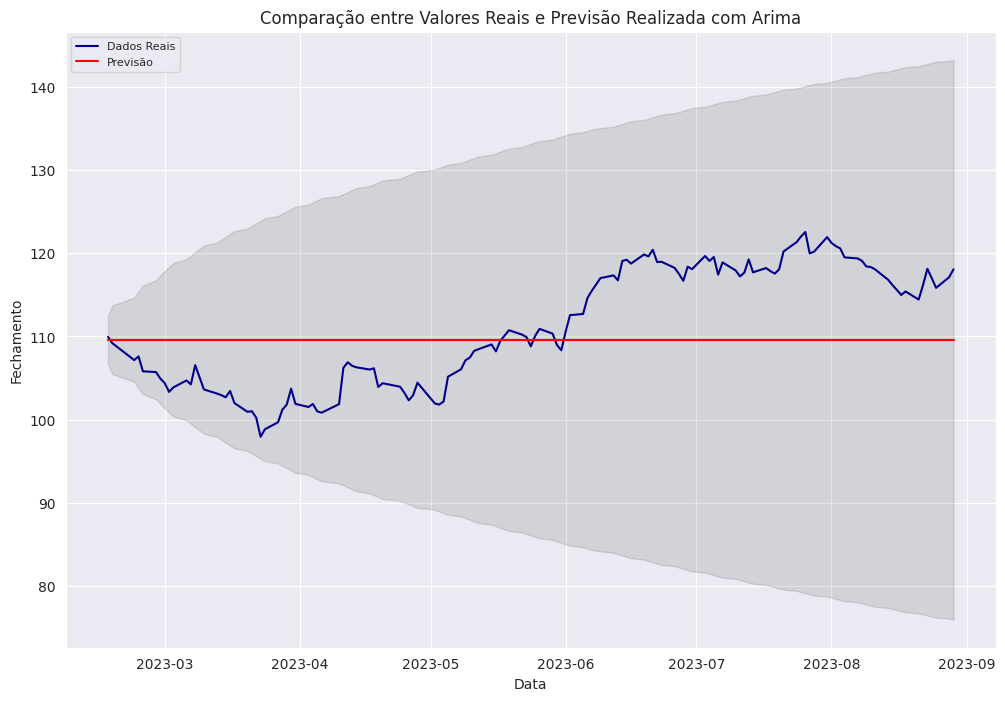

In [91]:
fc = pd.Series(forecast.values, index=test.sort_index().index)
lower = pd.Series(confint[:, 0], index=test.sort_index().index)
upper = pd.Series(confint[:, 1], index=test.sort_index().index)


plt.figure(figsize=(12,8))
plt.plot(test, color = 'darkblue', label='Dados Reais')
plt.plot(fc, color = 'red',label='Previsão')
plt.fill_between(lower.index, lower, upper, color='k', alpha=.1)
plt.title('Comparação entre Valores Reais e Previsão Realizada com Arima')
plt.xlabel('Data')
plt.ylabel('Fechamento')
plt.legend(loc='upper left', fontsize=8)
plt.show()

**Verificação da Performance do modelo**

In [92]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
import math

In [93]:
MAE = mean_absolute_error(test, forecast)
MSE = mean_squared_error(test, forecast)
RMSE= math.sqrt(mean_squared_error(test.values, forecast.values))
MAPE = np.mean(np.abs(forecast.values - test.values)/np.abs(test.values))



print('MAE',MAE) # Mean Absolute Error
print('MSE',MSE) # Erro Quadrático Médio
print('RMSE',RMSE) #Erro Quadrático Médio da Raiz
print('MAPE', MAPE) #Erro Percentual Absoluto Médio

MAE 6.492676691729323
MSE 52.77268404511278
RMSE 7.264480989383397
MAPE 0.05795261683783516


Calculando WMAPE

In [94]:
def wmape(y_true, y_pred, weights=None):

    absolute_diff = np.abs(y_true - y_pred)


    if weights is not None:
        weighted_absolute_diff = absolute_diff * weights
    else:
        weighted_absolute_diff = absolute_diff


    if weights is not None:
        weighted_true = y_true * weights
    else:
        weighted_true = y_true

    wmape = (np.sum(weighted_absolute_diff) / np.sum(weighted_true)) * 100

    return wmape


y_true = test['y'].values
y_pred = forecast


result_wmape = wmape(y_true, y_pred)
print(f"WMAPE: {result_wmape:.2f}%")

WMAPE: 5.84%


Criando mais um modelo com o Prophet

In [41]:
train = train.reset_index('ds')
train["unique_id"]= "Fechamento"

DEBUG:cmdstanpy:input tempfile: /tmp/tmp4c63fmab/37ocxois.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp4c63fmab/k1tmkp97.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=50168', 'data', 'file=/tmp/tmp4c63fmab/37ocxois.json', 'init=/tmp/tmp4c63fmab/k1tmkp97.json', 'output', 'file=/tmp/tmp4c63fmab/prophet_model84bxpprc/prophet_model-20230903205302.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
20:53:02 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
20:53:02 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


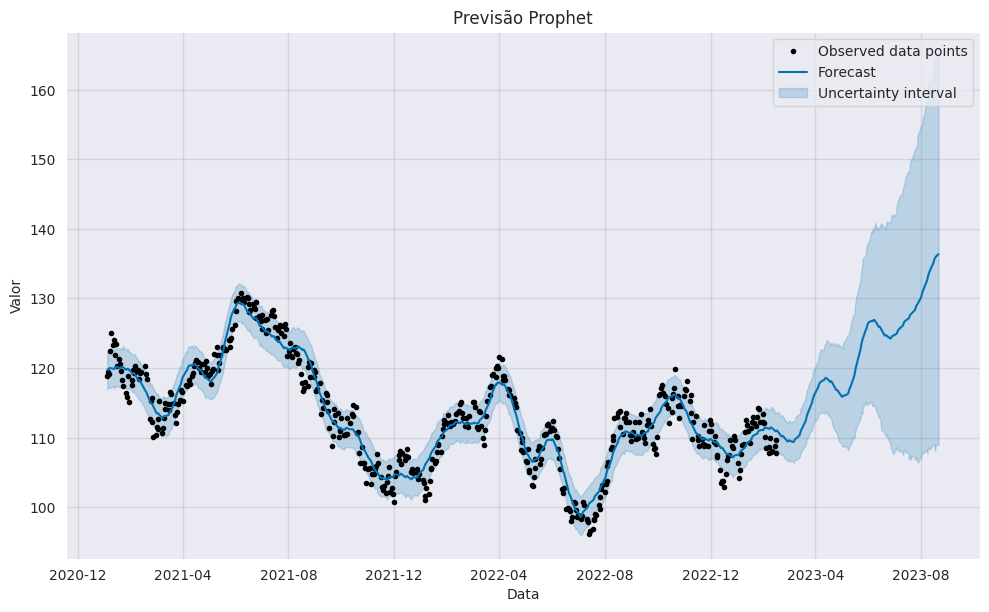

In [42]:
model_prophet = Prophet(daily_seasonality=True)

#utilizando o tamanho da base de teste na previsão
model_prophet.fit(train[['ds', 'y']])
future = model_prophet.make_future_dataframe(periods=187)

# datas de segunda(0) a sexta feria (4)
future['day'] = future['ds'].dt.weekday
future = future[future['day'] <= 4]

forecast_prophet = model_prophet.predict(future)
fig = model_prophet.plot(forecast_prophet)
plt.xlabel('Data')
plt.ylabel('Valor')
plt.title('Previsão Prophet')
plt.legend()
plt.grid(True)
plt.show()

In [43]:
test = test.reset_index('ds')
test["unique_id"]= "Fechamento"

Criando gráfico da Previsão realizada com o Prophet e comparando com os valores reais

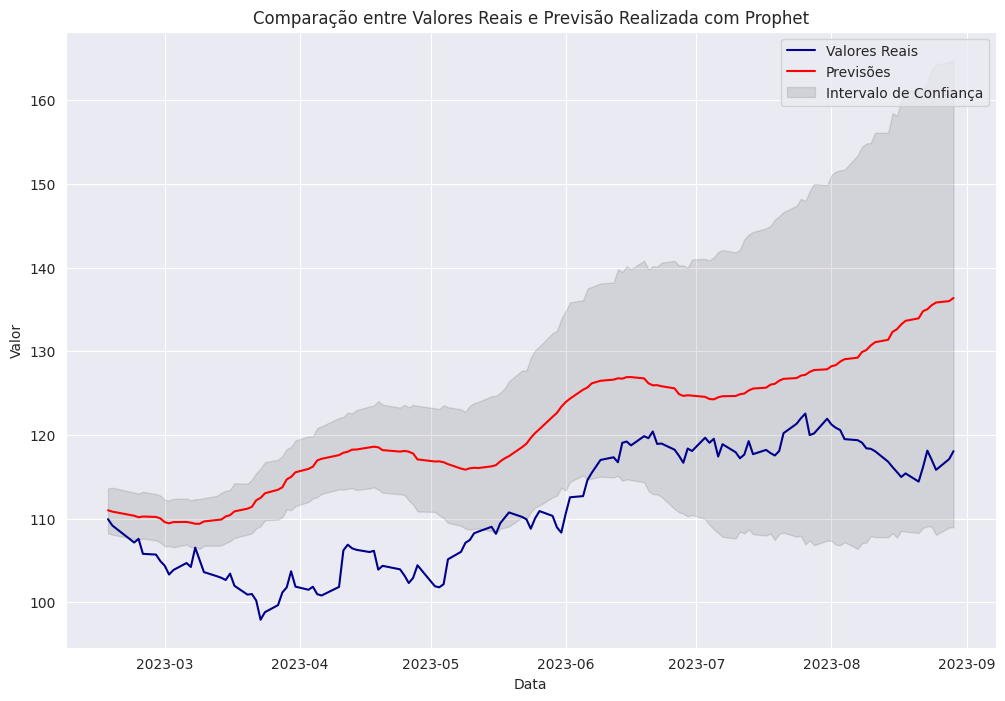

In [44]:

dates_test = test['ds']
values_real = test['y']

values_forecast = forecast_prophet['yhat']

lower = forecast_prophet['yhat_lower']
upper = forecast_prophet['yhat_upper']

plt.figure(figsize=(12, 8))
plt.plot(dates_test, values_real, color='darkblue', label='Valores Reais')
plt.plot(dates_test, values_forecast[-len(dates_test):], color='red', label='Previsões')
plt.fill_between(dates_test, lower[-len(dates_test):], upper[-len(dates_test):], color='k', alpha=0.1, label='Intervalo de Confiança')
plt.xlabel('Data')
plt.ylabel('Valor')
plt.title('Comparação entre Valores Reais e Previsão Realizada com Prophet')
plt.legend()
plt.grid(True)
plt.show()

**Avaliando Performance do modelo**

In [45]:
#Filtrando forecast para ficar do mesmo tamanho da base teste (com as mesmas datas)

forecast_filtered = forecast_prophet[forecast_prophet['ds'] >= '2023-02-16']

MAE = mean_absolute_error(test['y'].values, forecast_filtered['yhat'])
MSE = mean_squared_error(test['y'].values, forecast_filtered['yhat'])
RMSE= math.sqrt(mean_squared_error(test['y'].values, forecast_filtered['yhat']))
MAPE = np.mean(np.abs(forecast_filtered['yhat'] - test['y'].values)/np.abs(test['y'].values))



print('MAE',MAE) # Mean Absolute Error
print('MSE',MSE) # Erro Quadrático Médio
print('RMSE',RMSE) #Erro Quadrático Médio da Raiz
print('MAPE', MAPE) #Erro Percentual Absoluto Médio

MAE 9.944546170376963
MSE 116.74235176459783
RMSE 10.804737468564326
MAPE 0.09034261749601652


Calculando WMAPE

In [46]:
def wmape(y_true, y_pred, weights=None):

    absolute_diff = np.abs(y_true - y_pred)


    if weights is not None:
        weighted_absolute_diff = absolute_diff * weights
    else:
        weighted_absolute_diff = absolute_diff


    if weights is not None:
        weighted_true = y_true * weights
    else:
        weighted_true = y_true

    wmape = (np.sum(weighted_absolute_diff) / np.sum(weighted_true)) * 100

    return wmape


y_true = test['y'].values
y_pred = forecast_filtered['yhat']


result_wmape = wmape(y_true, y_pred)
print(f"WMAPE: {result_wmape:.2f}%")

WMAPE: 8.94%
